In [2]:
from prediction import extract_features


## Read audio file

In [3]:
from tools.audio import read_audio, play_audio, \
    get_spectrogram, convert_to_db, get_complex_spectrogram, inverse_complex_spectrogram
import matplotlib.pyplot as plt

In [4]:
# Load audio file
filename = 'audio/sounds/1-9886-A-49.wav'
audio, sr = read_audio(filename)

torch.Size([1, 1103, 500]) torch.float32 tensor(9.7130e-13) tensor(102545.9297)


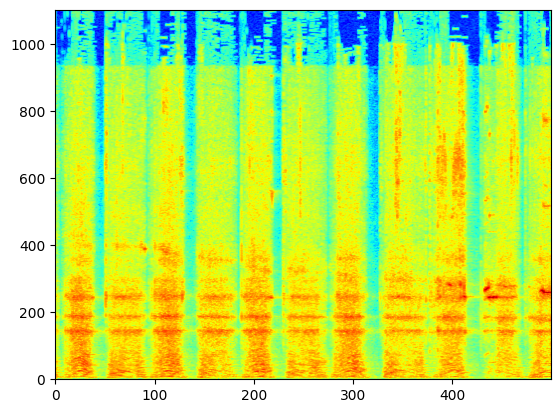

In [5]:
# Display spectrogram
spec = get_spectrogram(audio)
print(spec.shape, spec.dtype, spec.min(), spec.max())
spec_db = convert_to_db(spec)
plt.imshow(spec_db[0,:,:], origin='lower', cmap='jet', aspect='auto')
plt.show()

In [6]:
n_ftt = 2048

# Get complex spectrogram
cplx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
print(cplx_spec.shape, cplx_spec.dtype)
# Reconstruct audio from spectrogram
audio_from_spec = inverse_complex_spectrogram(cplx_spec, n_ftt=n_ftt)


torch.Size([1, 1025, 501]) torch.complex64


In [7]:
# play_audio(audio, sr)

In [8]:
# play_audio(audio_from_spec, sr)

## Masking audio in frequency space

In [9]:
from tools.masking import create_masks, apply_masks

In [10]:
n_ftt = 2048

# Get complex spectrogram
cplx_spec = get_complex_spectrogram(audio, n_ftt=n_ftt)
print(cplx_spec.shape, cplx_spec.dtype)

# Construct masks
spec_shape = cplx_spec.shape[1:3]
n_masks, n_freq, n_time, p = 100, 40, 25, 0.5
masks = create_masks(spec_shape, n_masks, n_freq, n_time, p=p)
print(masks.shape, masks.dtype)

# Apply masks
masked_spec = apply_masks(cplx_spec, masks)
print(masked_spec.shape, masked_spec.dtype)

torch.Size([1, 1025, 501]) torch.complex64
torch.Size([100, 1025, 501]) torch.bool
torch.Size([100, 1025, 501]) torch.complex64


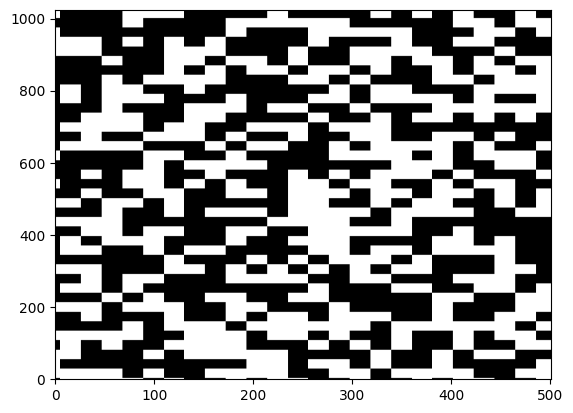

In [11]:
# Display first mask
first_mask = masks[1].numpy()

plt.imshow(first_mask, origin='lower', cmap='gray', aspect='auto')
plt.show()

In [12]:
masked_audios = inverse_complex_spectrogram(masked_spec, n_ftt=n_ftt)
print(masked_audios.shape, masked_audios.dtype)

torch.Size([100, 220500]) torch.float32


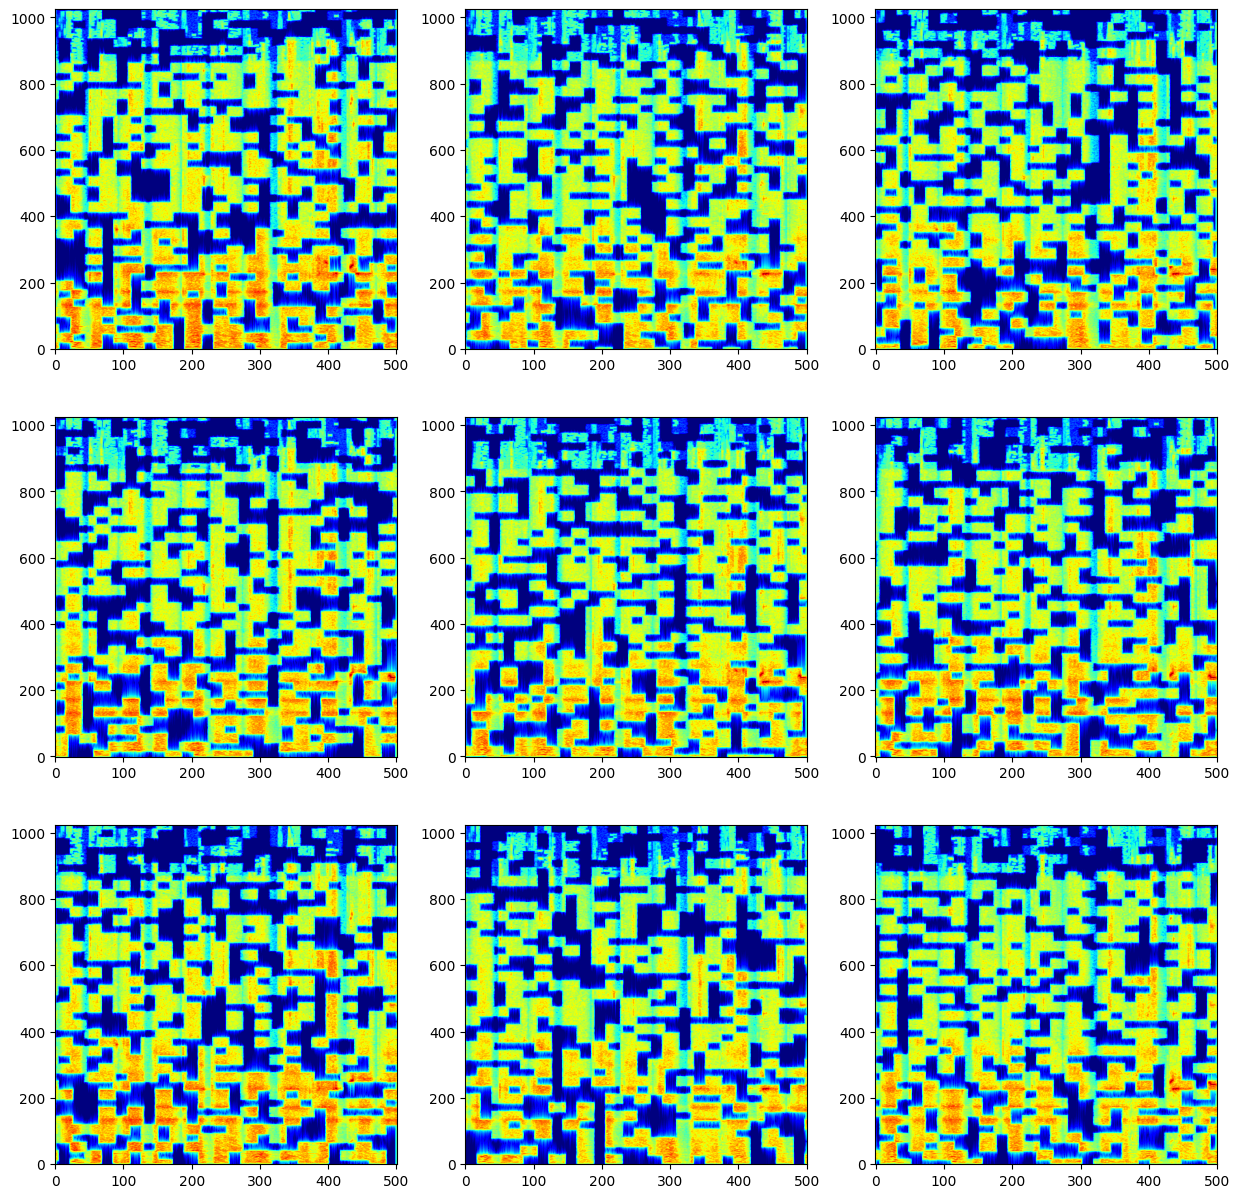

In [13]:
# Create and show masked spectrograms
plt.figure(figsize=(15,15))
for i in range(9):
    tmp_spec = get_spectrogram(masked_audios[i], n_ftt=n_ftt)
    tmp_spec_db = convert_to_db(tmp_spec)
    plt.subplot(3,3,i+1)
    plt.imshow(tmp_spec_db, origin='lower', cmap='jet', aspect='auto')
plt.show()


In [14]:
# Play masked audio
ix_audio = 20
# play_audio(masked_audios[ix_audio], sr)

## Get features with BEATS

In [15]:
from tools.audio import resample_audio
from prediction import load_beats_model

In [16]:
# Resample audio for the BEATS model
res_audio = resample_audio(audio, sr, 16000)
res_masked_audios = resample_audio(masked_audios, sr, 16000)

In [17]:
# Load BEATS model
model_path = 'audio/beats/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
beats_model = load_beats_model(model_path)

# Extract features of the original audio
original_features = beats_model.extract_features(res_audio)[0]

c:\ProgramData\Another_project_folder\DL_RELAX\.venv\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [18]:
# Extract features of the masked audios
masked_features = beats_model.extract_features(res_masked_audios)[0]

In [19]:
# Compute cosine similarity between original and masked features
import torch
from torch.nn.functional import cosine_similarity as cosine_sim

# Compute cosine similarity
cos_sim = cosine_sim(original_features, masked_features)
print(cos_sim.shape, cos_sim.dtype)

torch.Size([100]) torch.float32


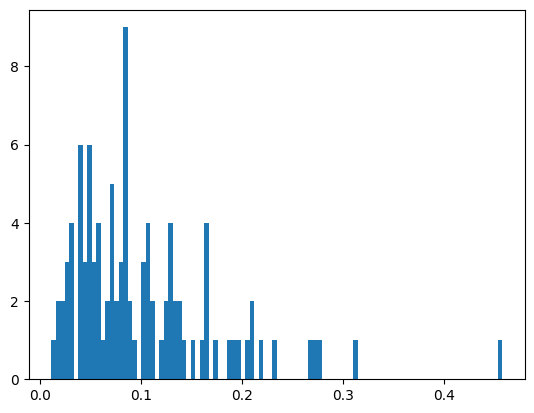

In [21]:
# Display similarity histogram
plt.hist(cos_sim.detach().numpy(), bins=100)
plt.show()